# Construction of a prediction model for Covid19
## Part 2 of the notebook (for part one look at the fork of covidclinicaldata

In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from colorama import Fore #To pain the terminal with different colors
import warnings
warnings.filterwarnings('ignore') #To disable warnings
from IPython.display import display #To print a dataframe like the cell does

In [107]:
all_data = pd.read_csv("covid_clinical_data.csv", index_col=0)
all_data

,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,autoimmune_dis,...,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
0,Negative,4,True,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
1,Negative,2,False,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
2,Negative,1,NaN,NaN,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Negative,3,True,True,False,False,False,False,False,False,...,True,2.0,False,True,False,False,False,False,False,True
4,Negative,1,False,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93989,Negative,3,False,True,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
93990,Negative,3,False,True,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,True,False,True
93991,Negative,3,False,False,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
93993,Negative,3,False,False,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False


In [108]:
X = all_data.iloc[:, 1:]
y = all_data["covid19_test_results"]

In [109]:
def create_different_datasets(data_x):
    e_factors = data_x.iloc[:,:3]
    comorbidities_data = data_x.iloc[:, 3:10] #The columns that contain the comorbidities
    vitals_data = data_x.iloc[:, 10:16] #The columns that contain the vitals
    assesed_symptoms_data = data_x.iloc[:, 16:21] #The columns that contain the assesed symptoms
    reported_symptoms_data = data_x.iloc[:,21:] #The columns that have the patient reported symptoms
    
    return e_factors, comorbidities_data, vitals_data, assesed_symptoms_data, reported_symptoms_data

In [110]:
e_factors, comorb, vitals, a_symptoms, r_symptoms = create_different_datasets(X)

<u>high_risk_exposure_occupation:</u> The most obvious thing to do is to just fill the 169 missing values with the most frequent value. However, it occurred to me that since we ultimately are willing to have (maybe even encourage) false positives, it might be better to just put the ones that tested positive as True and the rest as False. This would require that I split the dataset into training, validation and testing set before I do any imputation to avoid any target leakage (the effect when knowing the result before hand affects how are we imputing the variables). The step to be taken (if I were to follow that route) would be then to impute the training data that tested positive as True, the rest as False, and any incoming unknown data (validation and test data) as True if we dont know the value of the feature. I might need to run an experiment when I do both.

<u>high_risk_interaction:</u> This is easier than the previous one. We will just assign True to anything that has a 'high_risk_expossure_occupation' as True. The reasoning behind is is that if we don't know if the patient has had a high risk interaction, makes sense to say they did if their occupation is of high risk exposure.

In [111]:
def high_risk_exposure_imputation(data_x, data_y, target_imputation=False):    
    if target_imputation:
        mode = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]
    else:
        mode = True
    data_x.loc[data_x["high_risk_exposure_occupation"].isna(), "high_risk_exposure_occupation"] = mode
    
    data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]

def vitals_imputation_generic(data_x):
    data = data_x.copy()
    data.loc[data["temperature"].isna(),"temperature"] = data["temperature"].mean()
    data.loc[data["pulse"].isna(),"pulse"] = data["pulse"].median()
    data.loc[data["rr"].isna(),"rr"] = data["rr"].median()
    data.loc[data["sats"].isna(),"sats"] = data["sats"].median()
    data.loc[data_x["pam"].isna(), "pam"] = data_x["pam"].mean()
    
    return data


In [112]:
def reduce_training_set(data_x, data_y):
    selected_negatives = data_x[data_y[data_x.index] == "Negative"].sample((data_y[data_x.index] == "Positive").sum())
    all_positives = data_x[data_y == "Positive"]
    #reduced_train_comorb = pd.merge(all_positives, selected_negatives) #Doesn't work well for reasons...
    reduced_data = pd.concat([all_positives, selected_negatives])

    return reduced_data

def get_metrics(*values):
    accuracy = accuracy_score(*values)
    recall = recall_score(*values, pos_label="Positive")
    precision = precision_score(*values, pos_label="Positive")
    f1 = f1_score(*values, pos_label="Positive")
    return accuracy, recall, precision, f1


In [113]:
class Imputer():
    
    def __init__(self):
        self.column_values = {}
        
    def fit_transform(self, data_x, data_y):
        self.fit(data_x, data_y)
        self.transform(data_x, training=True)
        
    def fit(self, data_x, data_y):
        self.get_high_risk_exposure_value(data_x, data_y)
        self.get_vitals_values(data_x)
        self.get_a_symptoms_values(data_x)
        self.get_r_symptoms_values(data_x)
        
    def transform(self, data_x, training=False):
        for feature in data_x.columns:           
            
            if feature in self.column_values:
                new_value = self.column_values[feature]
                
                if feature == "high_risk_exposure_occupation" and not training:
                    new_value=True
                    
                data_x.loc[data_x[feature].isna(), feature] = new_value
                
        if "high_risk_interactions" in data_x.columns: #Because this depends on 'high_risk_exposure_occupation being imputed first'
            data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]
        
        
        
    def get_high_risk_exposure_value(self, data_x, data_y):
        if "high_risk_exposure_occupation" in data_x.columns:
            self.column_values["high_risk_exposure_occupation"] = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]

        
    def get_vitals_values(self, data_x):
        if "temperature" in data_x.columns:
            self.column_values["temperature"] =  data_x["temperature"].mean()
        if "pulse" in data_x.columns:
            self.column_values["pulse"] = data_x["pulse"].median()
        if "rr" in data_x.columns:
            self.column_values["rr"] = data_x["rr"].median()
        if "sats" in data_x.columns:
            self.column_values["sats"] = data_x["sats"].median()
        if "pam" in data_x.columns:
            self.column_values["pam"] =  data_x["pam"].mean()
            
    def get_a_symptoms_values(self, data_x):
        
        if "ctab" in data_x.columns:
            self.column_values["ctab"] = data_x["ctab"].mode()[0]
            
        if "labored_respiration" in data_x.columns:
            self.column_values["labored_respiration"] = data_x["labored_respiration"].mode()[0]
            
        if "rhonchi" in data_x.columns:
            self.column_values["rhonchi"] = data_x["rhonchi"].mode()[0]
            
        if "wheezes" in data_x.columns:
            self.column_values["wheezes"] = data_x["wheezes"].mode()[0]
            
        if "days_since_symptom_onset" in data_x.columns:
            self.column_values["days_since_symptom_onset"] = data_x["days_since_symptom_onset"].median()
            
    def get_r_symptoms_values(self, data_x):
        if "cough" in data_x.columns:
            self.column_values["cough"] = data_x["cough"].mode()[0]
            
        if "cough_severity" in data_x.columns:
            self.column_values["cough_severity"] = data_x["cough_severity"].mode()[0]
            
        if "fever" in data_x.columns:
            self.column_values["fever"] = data_x["fever"].mode()[0]
            
        if "sob" in data_x.columns:
            self.column_values["sob"] = data_x["sob"].mode()[0]
            
        if "sob_severity" in data_x.columns:
            self.column_values["sob_severity"] = data_x["sob_severity"].mode()[0]
        
        if "diarrhea" in data_x.columns:
            self.column_values["diarrhea"] = data_x["diarrhea"].mode()[0]
            
        if "fatigue" in data_x.columns:
            self.column_values["fatigue"] = data_x["fatigue"].mode()[0]
            
        if "headache" in data_x.columns:
            self.column_values["headache"] = data_x["headache"].mode()[0]
            
        if "loss_of_smell" in data_x.columns:
            self.column_values["loss_of_smell"] = data_x["loss_of_smell"].mode()[0]
            
        if "loss_of_taste" in data_x.columns:
            self.column_values["loss_of_taste"] = data_x["loss_of_taste"].mode()[0]
    
        if "runny_nose" in data_x.columns:
            self.column_values["runny_nose"] = data_x["runny_nose"].mode()[0]
            
        if "muscle_sore" in data_x.columns:
            self.column_values["muscle_sore"] = data_x["muscle_sore"].mode()[0]
            
        if "sore_throat" in data_x.columns:
            self.column_values["sore_throat"] = data_x["sore_throat"].mode()[0]

In [114]:
class XGBAdapter:
    
    def __init__(self, **params):
        self.model = XGBClassifier(**params, verbosity=0)
        
    def fit(self, data_x, data_y):
        self.model.fit(self.xgb_adapter(data_x), data_y)
        
    def predict(self, data_x):
        return self.model.predict(self.xgb_adapter(data_x))
        
    #This function is because xgb complains about 'object' type columns so I convert them all to boolean
    def xgb_adapter(self, data_x):
        result = data_x.copy()
        for column in result:
            if data_x[column].dtype == "object":
                result.loc[:,column] = result[column].astype("bool")
        return result

In [115]:
def cross_validation_normal(data_x, data_y, model, folds):
    results = np.zeros((folds,2,4)) #Shape of folds, training and validation, and number of metrics
    
    fold_size = data_x.shape[0] // folds
    reminder = data_x.shape[0] % folds    
    start = 0    
    imputer = Imputer()
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1
        train_x = pd.concat([data_x.iloc[:start], data_x.iloc[end:]], axis=0)
        train_y = data_y.iloc[:start].append(data_y.iloc[end:])
        valid_x = data_x.iloc[start:end]
        valid_y = data_y.iloc[start:end]
        
        #if hr_imputation:
            #high_risk_exposure_imputation(train_x, train_y, target_imputation = True)
            #high_risk_exposure_imputation(valid_x, valid_y)
            
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
            
        model.fit(train_x, train_y)
        train_v = (train_y, model.predict(train_x))
        valid_v = (valid_y, model.predict(valid_x))
        results[i,0] += get_metrics(*train_v)
        results[i,1] += get_metrics(*valid_v)
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
    print("")
    return results.mean(axis=0)

def cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=1):
    
    positive_index = data_y[data_y == "Positive"].index
    size_of_negatives = positive_index.shape[0] * ratio_negatives_to_positives
    
    fold_size = positive_index.shape[0] // folds
    results = np.zeros((folds,2,4)) #Shape of folds, training and validation, and number of metrics   
        
    reminder = positive_index.shape[0] % folds
    
    imputer = Imputer()
    start = 0    
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1        
        training_positives = np.setdiff1d(positive_index, positive_index[start:end]) #The index of positives to be used as training set
                
        # Sample the size of negatives- the size of the fold negatives for training and concatenate with the corresponding indexes for the fold
        train_x = pd.concat([data_x[data_y == "Negative"].sample(size_of_negatives - fold_size), data_x.loc[training_positives]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        train_y = data_y[train_x.index]
        valid_x = pd.concat([data_x[data_y == "Negative"].sample(fold_size * ratio_negatives_to_positives), data_x.loc[positive_index[start:end]]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        valid_y = data_y[valid_x.index]
        
        #if hr_imputation:
            #high_risk_exposure_imputation(train_x, train_y, target_imputation = True)
            #high_risk_exposure_imputation(valid_x, valid_y)
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
        
            
        model.fit(train_x, train_y)
        train_v = (train_y, model.predict(train_x))
        valid_v = (valid_y, model.predict(valid_x))
        results[i,0] += get_metrics(*train_v)
        results[i,1] += get_metrics(*valid_v)
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
    print("")
    return results.mean(axis=0)
    
        
def run_models(data_x, data_y, models, folds=10, ratio_negatives_to_positives=-1):
    for model in models:
        print(Fore.RED, model, Fore.BLACK, sep="")
        if(ratio_negatives_to_positives >= 1):            
            results = cross_validation_class_ratios(data_x, data_y, models[model], folds, ratio_negatives_to_positives)
        else:
            results = cross_validation_normal(data_x, data_y, models[model], folds)    
            
        display(pd.DataFrame(results, index=["Training", "Validation"], columns=["Accuracy", "Recall", "Precision", "F1"]))
        print("")

In [116]:
models ={
    "MultinomialNB" : MultinomialNB(alpha=0, class_prior=(.5, .5)),
    "Random Forest (100 estimators)" : RandomForestClassifier(min_samples_leaf=30),
    "XGBoost Classifier" : XGBAdapter(n_estimators=500),
    "SVM" : SVC(), 
    "KNN" : KNeighborsClassifier(weights="distance", algorithm="brute")
}

In [117]:
run_models(comorb, y[comorb.index], models)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.904953,0.083474,0.026178,0.039854
Validation,0.905138,0.082413,0.024478,0.037117



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.976361,0.0,0.0,0.0
Validation,0.976362,0.0,0.0,0.0



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.976361,0.0,0.0,0.0
Validation,0.976362,0.0,0.0,0.0



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.976361,0.0,0.0,0.0
Validation,0.976362,0.0,0.0,0.0



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.976342,0.00029,0.02,0.000572
Validation,0.976304,0.00000,0.00,0.000000


In [118]:
reduced_comorb = reduce_training_set(comorb, y)
run_models(reduced_comorb, y[reduced_comorb.index], models)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.503964,0.090020,0.527231,0.152798
Validation,0.504369,0.043382,0.500000,0.079521



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.555465,0.5,0.277727,0.357101
Validation,0.000820,0.0,0.000000,0.000000



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.560648,0.502188,0.599309,0.384822
Validation,0.032742,0.013913,0.500000,0.026941



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.560784,0.502823,0.603811,0.384189
Validation,0.029470,0.012280,0.500000,0.023853



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.503873,0.069082,0.586241,0.11731
Validation,0.507255,0.032688,0.500000,0.06023


In [119]:
comorb_ef = pd.concat([comorb, e_factors], axis=1)
run_models(comorb_ef, y, models)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.717952,0.336155,0.030852,0.054799
Validation,0.708068,0.284088,0.025299,0.044059



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.976361,0.0,0.0,0.0
Validation,0.976362,0.0,0.0,0.0



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.976460,0.004175,1.0,0.008314
Validation,0.976304,0.000000,0.0,0.000000



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.976361,0.0,0.0,0.0
Validation,0.976362,0.0,0.0,0.0



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.976462,0.004278,1.0,0.008518
Validation,0.976323,0.000000,0.0,0.000000


In [120]:
reduced_comorb_ef = reduce_training_set(comorb_ef, y)
run_models(reduced_comorb_ef, y[reduced_comorb_ef.index], models)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.525373,0.292695,0.577817,0.355035
Validation,0.584237,0.164717,0.497826,0.221929



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.567057,0.513701,0.567128,0.427553
Validation,0.076942,0.031908,0.493333,0.059539



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.588379,0.543629,0.602226,0.497506
Validation,0.160012,0.073259,0.497500,0.127474



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.572558,0.541187,0.579727,0.469611
Validation,0.116614,0.059346,0.496970,0.104458



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.54551,0.411066,0.555212,0.458589
Validation,0.41141,0.134100,0.500000,0.204919


Next step to either add more features or... implement a cross validation method that makes up for the difference between positives and negatives

In [121]:
run_models(comorb, y[comorb.index], models, ratio_negatives_to_positives = 1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.504955,0.075286,0.565878,0.128056
Validation,0.503285,0.068726,0.521771,0.117861



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.515456,0.801440,0.512981,0.594231
Validation,0.502031,0.790257,0.477240,0.578845



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.519592,0.905253,0.511100,0.653093
Validation,0.499990,0.891157,0.499864,0.640031



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.518092,0.887531,0.510390,0.647986
Validation,0.506537,0.873910,0.503769,0.638755



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.510319,0.916077,0.505784,0.651491
Validation,0.502459,0.896881,0.501408,0.642874


In [122]:
run_models(comorb_ef, y[comorb_ef.index], models, ratio_negatives_to_positives = 1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.537503,0.403822,0.573515,0.420682
Validation,0.523324,0.362255,0.541009,0.378354



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.553550,0.589191,0.552561,0.561396
Validation,0.533993,0.557377,0.535186,0.534564



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.571734,0.589950,0.571949,0.57481
Validation,0.529512,0.559596,0.531452,0.53912



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.550096,0.483108,0.567643,0.502942
Validation,0.511449,0.422065,0.508450,0.443863



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.539775,0.478262,0.545446,0.506098
Validation,0.503685,0.452526,0.503947,0.473393


In [123]:
weighted_trees = {
    "Random Forest (100 estimators)" : RandomForestClassifier(min_samples_leaf=30, class_weight={"Positive" : 1, "Negative" : .5}),
    "Random Forest (500 estimators)" : RandomForestClassifier(n_estimators = 500, class_weight={"Positive" : 1, "Negative" : .5})
}

In [124]:
run_models(comorb_ef, y[comorb_ef.index], weighted_trees, ratio_negatives_to_positives=1)

Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.499955,1.0,0.499955,0.666626
Validation,0.500408,1.0,0.500408,0.667029



Random Forest (500 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.540549,0.971268,0.521944,0.678878
Validation,0.510221,0.937792,0.505569,0.656770


We definetley need another set, even though using the cross validation for data imbalancing helped a lot

### Vitals

$ PAM = DIA + \frac{SIS-DIA}{3}$<br>
where PAM = Presión arterial media
SIS = Sístole
DIA = Diástole

In [125]:
def calculate_pam(data_x):
    return vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)

In [126]:

pam = vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)
vitals = pd.concat([vitals, pam], axis=1)
vitals.rename({ 0 : "pam"}, axis=1,inplace =True) #To rename the column that was appended (which has a value of 0 that is not a string)
i = vitals[vitals.iloc[:,-1] >145].iloc[:,-1].index
pd.concat([vitals.loc[i, ["sys", "dia"]], e_factors.loc[i,"age"]], axis=1)

,sys,dia,age
5135,195.0,135.0,4
6106,215.0,115.0,4
9058,200.0,120.0,3
11792,190.0,130.0,3
14314,205.0,125.0,4
19137,215.0,117.0,4
20168,190.0,130.0,4
20379,220.0,140.0,4
20582,200.0,118.0,4
28579,180.0,130.0,3


As expected, all pressure variables (including pam) are correlated between each other

In [127]:
#Drop all values that are Nan
vitals.dropna(how="all",inplace=True)
vitals.drop(columns=["sys", "dia"], inplace=True) #Because we have 'pam' we don't need it anymore (I ran some experiments and it is sligthly better with 'pam')
vitals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48705 entries, 0 to 93994
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  46961 non-null  float64
 1   pulse        47666 non-null  float64
 2   rr           40972 non-null  float64
 3   sats         46959 non-null  float64
 4   pam          45990 non-null  float64
dtypes: float64(5)
memory usage: 2.2 MB


<AxesSubplot:>

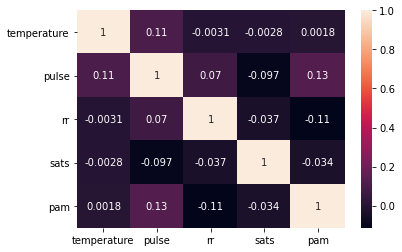

In [128]:
sns.heatmap(vitals.corr(), annot=True)

In [129]:
vital_models = {
    
    "Random Forest" : RandomForestClassifier(),
    "XGBClassifier" : XGBAdapter(),
    "Logistic Regression" : LogisticRegression(),
    "SVM" : SVC()

}

In [130]:
run_models(vitals, y[vitals.index], vital_models, ratio_negatives_to_positives=-1)
run_models(vitals, y[vitals.index], vital_models, ratio_negatives_to_positives=1)

Random Forest
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.998770,0.947388,0.997853,0.971961
Validation,0.976451,0.000446,0.014286,0.000866



XGBClassifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.978809,0.060676,1.000000,0.114338
Validation,0.977108,0.003452,0.192424,0.006759



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.977397,0.0,0.0,0.0
Validation,0.977354,0.0,0.0,0.0



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.977436,0.0,0.0,0.0
Validation,0.977436,0.0,0.0,0.0



Random Forest
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.999343,0.999393,0.999293,0.999343
Validation,0.564662,0.532327,0.570498,0.549472



XGBClassifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.935879,0.930844,0.940281,0.935507
Validation,0.550922,0.543186,0.554401,0.547633



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.590371,0.558287,0.596443,0.576711
Validation,0.583826,0.545963,0.588958,0.564239



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.566015,0.629054,0.558549,0.590953
Validation,0.551850,0.625188,0.547301,0.581327


In [131]:
vitals_ex = pd.merge(vitals, e_factors, left_index=True, right_index=True)
run_models(vitals_ex, y[vitals_ex.index], vital_models, ratio_negatives_to_positives=1)

Random Forest
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.999949,0.999899,1.000000,0.999949
Validation,0.596596,0.558649,0.605243,0.579916



XGBClassifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.965641,0.963401,0.967742,0.965551
Validation,0.558726,0.533244,0.564879,0.547665



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.592744,0.570619,0.597149,0.583422
Validation,0.589755,0.555963,0.596732,0.572936



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.565459,0.556769,0.567040,0.560764
Validation,0.552771,0.545997,0.554054,0.545969


In [132]:
vitals_comorb = pd.merge(vitals, comorb, left_index=True, right_index=True)
run_models(vitals_comorb, y[vitals_comorb.index], vital_models, ratio_negatives_to_positives=1)

Random Forest
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.999646,0.999697,0.999596,0.999646
Validation,0.571495,0.540500,0.578391,0.557678



XGBClassifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.938963,0.932667,0.944531,0.938544
Validation,0.547281,0.544145,0.549644,0.546344



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.586226,0.563339,0.590124,0.576382
Validation,0.574693,0.544120,0.580179,0.558374



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.569602,0.551917,0.572590,0.561261
Validation,0.574234,0.545997,0.579259,0.559938


In [133]:
vitals_comorb_ex = pd.merge(vitals_comorb, e_factors, left_index=True, right_index=True)
run_models(vitals_comorb_ex, y[vitals_comorb_ex.index], vital_models, ratio_negatives_to_positives=1)

Random Forest
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.999899,0.999798,1.000000,0.999899
Validation,0.562352,0.522302,0.569771,0.543361



XGBClassifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.962508,0.960873,0.964011,0.962430
Validation,0.571949,0.550500,0.575935,0.561867



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.590824,0.568193,0.594920,0.581238
Validation,0.571495,0.553203,0.574454,0.561355



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.569400,0.551411,0.571931,0.561189
Validation,0.565104,0.545980,0.567899,0.555436


### Assesed Symptoms

In [134]:
a_symptoms.dropna(how="all", inplace=True)

In [135]:
run_models(a_symptoms, y[a_symptoms.index], models)
run_models(a_symptoms, y[a_symptoms.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.251134,0.848767,0.026174,0.050780
Validation,0.251109,0.831910,0.025442,0.049163



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.976399,0.0,0.0,0.0
Validation,0.976399,0.0,0.0,0.0



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.976443,0.002428,0.841667,0.00484
Validation,0.976340,0.000000,0.000000,0.00000



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.976399,0.0,0.0,0.0
Validation,0.976399,0.0,0.0,0.0



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.976443,0.001871,1.0,0.003734
Validation,0.976359,0.000000,0.0,0.000000



MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.544210,0.848373,0.527501,0.650499
Validation,0.537089,0.842262,0.522754,0.644936



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.589421,0.399275,0.644223,0.492916
Validation,0.573241,0.396485,0.614653,0.479445



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.604834,0.402906,0.675921,0.504777
Validation,0.590855,0.379783,0.656362,0.479743



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.538996,0.572894,0.575382,0.499162
Validation,0.529127,0.565581,0.547100,0.485052



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.572567,0.628686,0.597531,0.577703
Validation,0.547228,0.612675,0.569843,0.557405


In [136]:
a_symptoms_ef = pd.merge(a_symptoms, e_factors, left_index=True, right_index=True)
run_models(a_symptoms_ef, y[a_symptoms_ef.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.554173,0.742017,0.539071,0.623198
Validation,0.558484,0.745763,0.540676,0.624470



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.603622,0.536087,0.623012,0.572485
Validation,0.569417,0.503718,0.583294,0.535774



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.650697,0.635924,0.657898,0.644093
Validation,0.560622,0.530616,0.568315,0.545003



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.567816,0.580256,0.575798,0.561509
Validation,0.530031,0.537115,0.524256,0.513764



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.620618,0.647753,0.620185,0.627649
Validation,0.541746,0.574258,0.543635,0.554288


In [137]:
a_symptoms_comorb = pd.merge(a_symptoms, comorb, left_index=True, right_index=True)
run_models(a_symptoms_comorb, y[a_symptoms_comorb.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.551706,0.818381,0.533742,0.645922
Validation,0.548441,0.810413,0.531753,0.641501



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.590585,0.449554,0.638312,0.516370
Validation,0.575759,0.440196,0.613541,0.498701



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.622574,0.444538,0.690613,0.540268
Validation,0.580351,0.390672,0.630353,0.481027



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.549704,0.655443,0.573251,0.549841
Validation,0.539622,0.632318,0.518658,0.523609



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.600225,0.417539,0.662016,0.507623
Validation,0.551825,0.361232,0.582217,0.442465


In [138]:
a_symptoms_comorb_ef = pd.merge(a_symptoms, comorb_ef, left_index=True, right_index=True)
run_models(a_symptoms_comorb_ef, y[a_symptoms_comorb_ef.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.556688,0.684349,0.544854,0.603896
Validation,0.537532,0.655448,0.528347,0.581828



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.603855,0.558727,0.616181,0.583094
Validation,0.586229,0.525455,0.600600,0.555956



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.673092,0.602381,0.707136,0.645796
Validation,0.567341,0.464538,0.588165,0.513046



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.585882,0.487213,0.611204,0.536181
Validation,0.552639,0.449006,0.565006,0.492161



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.658285,0.629024,0.676203,0.645457
Validation,0.536683,0.504727,0.545454,0.517779


In [140]:
a_symptoms_comorb_ef_vitals = pd.merge(vitals, a_symptoms_comorb_ef, left_index=True, right_index=True)
run_models(a_symptoms_comorb_ef_vitals, y[a_symptoms_comorb_ef_vitals.index], models, ratio_negatives_to_positives=1)
run_models(a_symptoms_comorb_ef_vitals, y[a_symptoms_comorb_ef_vitals.index], vital_models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.585595,0.629630,0.578944,0.602969
Validation,0.579406,0.616389,0.575876,0.594269



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.676490,0.644450,0.688904,0.665635
Validation,0.624211,0.586122,0.634305,0.607362



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.999949,1.000000,0.999899,0.999949
Validation,0.579383,0.562385,0.582267,0.570778



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.568602,0.544795,0.572150,0.557856
Validation,0.573906,0.542452,0.578348,0.559048



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.999949,0.999899,1.000000,0.999949
Validation,0.562448,0.546030,0.567891,0.555732



Random Forest
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.999949,0.999899,1.00000,0.999949
Validation,0.615062,0.572535,0.62579,0.597192



XGBClassifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.963530,0.954338,0.972158,0.963152
Validation,0.602268,0.580734,0.607936,0.593707



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.606035,0.599695,0.607392,0.603493
Validation,0.587550,0.569600,0.589569,0.578322



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.568805,0.544899,0.572432,0.558152
Validation,0.572540,0.545146,0.575910,0.558644


### Reported symptoms

In [141]:
r_symptoms

,cough,cough_severity,fever,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
0,True,3.0,NaN,False,0.0,False,False,False,False,False,False,False,False
1,True,1.0,False,False,0.0,False,False,False,False,False,False,False,False
2,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,2.0,False,True,2.0,False,True,False,False,False,False,False,True
4,True,1.0,False,False,0.0,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93989,False,0.0,False,False,0.0,False,False,False,False,False,False,False,False
93990,True,2.0,False,False,0.0,False,False,False,False,False,True,False,True
93991,False,0.0,True,False,0.0,False,False,False,False,False,False,False,False
93993,False,0.0,False,False,0.0,False,False,False,False,False,False,False,False


In [142]:
r_symptoms.dropna(how="all", inplace=True)

In [146]:
run_models(r_symptoms, y[r_symptoms.index], vital_models)
run_models(r_symptoms, y[r_symptoms.index], vital_models, ratio_negatives_to_positives=1)

Random Forest
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.978586,0.113476,0.856018,0.200339
Validation,0.975235,0.017905,0.260385,0.032621



XGBClassifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.978113,0.086108,0.881028,0.156855
Validation,0.975448,0.019233,0.267308,0.035303



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.976376,0.027089,0.507419,0.051426
Validation,0.976222,0.024967,0.492857,0.046420



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.977171,0.037872,0.921173,0.072715
Validation,0.976202,0.007663,0.360000,0.014929



Random Forest
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.704927,0.507637,0.838651,0.632299
Validation,0.638801,0.465527,0.713526,0.559338



XGBClassifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.701109,0.506545,0.829301,0.628788
Validation,0.648213,0.449200,0.745680,0.558781



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.663242,0.485725,0.753238,0.590455
Validation,0.664597,0.476176,0.761626,0.582024



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.683335,0.500816,0.788892,0.612537
Validation,0.645764,0.469639,0.723405,0.565496


In [144]:
run_models(r_symptoms.drop(columns=["sob", "cough"]), y[r_symptoms.index], vital_models)
run_models(r_symptoms.drop(columns=["sob", "cough"]), y[r_symptoms.index], vital_models, ratio_negatives_to_positives=1)

Random Forest
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.978586,0.113179,0.857905,0.199908
Validation,0.975216,0.014682,0.249038,0.027003



XGBClassifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.978113,0.086108,0.881028,0.156855
Validation,0.975448,0.019233,0.267308,0.035303



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.976131,0.017452,0.392278,0.033400
Validation,0.976009,0.015813,0.383592,0.028819



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.977266,0.043017,0.906924,0.082108
Validation,0.976164,0.007265,0.366667,0.014173



Random Forest
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.705473,0.502638,0.845943,0.630281
Validation,0.645343,0.458990,0.728257,0.560868



XGBClassifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.701245,0.500181,0.836858,0.626002
Validation,0.640032,0.431228,0.738619,0.542693



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.665379,0.479905,0.762983,0.589068
Validation,0.655594,0.481101,0.734051,0.579121



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.685289,0.505182,0.789693,0.616066
Validation,0.651082,0.473704,0.732349,0.571480


In [145]:
run_models(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), y[r_symptoms.index], vital_models)
run_models(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), y[r_symptoms.index], vital_models, ratio_negatives_to_positives=1)

Random Forest
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.977891,0.084696,0.811681,0.153347
Validation,0.975370,0.014274,0.240125,0.026429



XGBClassifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.977786,0.074548,0.841682,0.136922
Validation,0.975390,0.022300,0.312143,0.040956



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.976318,0.027031,0.487284,0.051194
Validation,0.976164,0.024435,0.561449,0.045240



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.977096,0.038299,0.847699,0.073234
Validation,0.976067,0.006786,0.406667,0.013226



Random Forest
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.697791,0.498545,0.829389,0.622485
Validation,0.649026,0.449147,0.744448,0.557589



XGBClassifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.696063,0.499363,0.823748,0.621467
Validation,0.645768,0.445888,0.742497,0.553722



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.663196,0.493996,0.748756,0.594264
Validation,0.662554,0.488471,0.749719,0.585823



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,F1
Training,0.687744,0.508090,0.793162,0.619182
Validation,0.647404,0.474597,0.723439,0.570886
